# Akash Das (MDS202206)

## Use kaggle to Access GPU for Model Fine Tuning


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


## Import Required Libraries

In [ ]:
import torch
import transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import os, sys, random
import datetime, time, copy
import torch, warnings
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from transformers import BertForSequenceClassification, BertTokenizerFast
from PIL import Image
import pandas as pd

# specify GPU
device = torch.device("cuda")

warnings.filterwarnings("ignore")
%matplotlib inline

### Load Data

In [ ]:
import pandas as pd
df=pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv",encoding="iso-8859-1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Use kaggle GPU for Model Fine Tuning

In [ ]:
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

Using GPU:  True


### Data Preprocessing

In [ ]:
import re
def preprocessing(text):
  regex = r'[^\w\s]|[\U0001f600-\U0001f64f\U0001f300-\U0001f5ff\U0001f680-\U0001f6ff\U0001f1e0-\U0001f1ff]'
  text=re.sub(regex," ",text)
  text=re.sub("\.|\,|\/|\-"," ",text)
  text=re.sub("\s*\s"," ",text)
  return text

In [ ]:
for i in range(len(df)):
  df.loc[i,"text"]=preprocessing(str(df.loc[i,"text"]))

In [ ]:
df["sentiment"]=df["sentiment"].replace({"neutral":0,"positive":1,"negative":2})

In [ ]:
df=df[["text","sentiment"]]

In [ ]:
df.head()

,text,sentiment
0,I d have responded if I were going,0
1,Sooo SAD I will miss you here in San Diego,2
2,my boss is bullying me,2
3,what interview leave me alone,2
4,Sons of why couldn t they put them on the rel...,2


In [ ]:
df["sentiment"].value_counts()

sentiment
0    11118
1     8582
2     7781
Name: count, dtype: int64

### Split the dataset into three sets – train, validation, and test.

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['sentiment'],
                                                                    random_state=2024,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2024,
                                                                test_size=0.5,
                                                                stratify=temp_labels)


### Import BERT Model and BERT Tokenizer

In [ ]:

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Let’s see how this BERT tokenizer works. We will try to encode a couple of sentences using the tokenizer.

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Tokenize the Sentences

<Axes: >

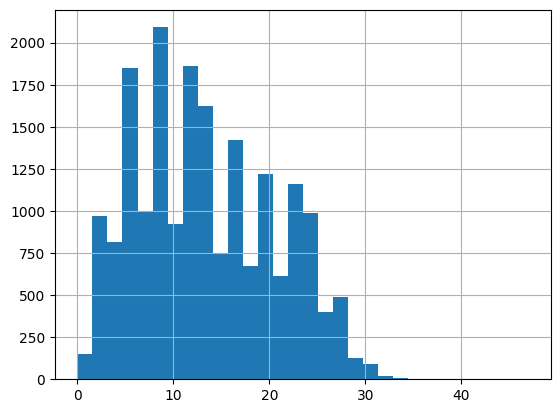

In [ ]:

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

### Convert the integer sequences to tensors.

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Now we will create dataloaders for both train and validation set

In [ ]:
batch_size = 32

# Warping, sampling the training data and creating dataLoader object
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Warping, sampling the validation data and creating dataLoader object
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Define Model Architecture

In [ ]:

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for pos/neu/neg classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# pass the pre-trained BERT to our define architecture
# push the model to GPU
model = model.to(device)
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


### use AdamW as our optimizer.

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate


# # Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# # 'W' stands for 'Weight Decay fix"



### There is a class imbalance in our dataset. The majority of the observations are neutral. So, we will first compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance.

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute the class weights
# class_labels = np.unique(train_labels)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )

print("Class Weights:", class_weights)

Class Weights: [0.82395271 1.06742134 1.17716174]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

### Define Required Functions to Fine-Tune BERT

So, till now we have defined the model architecture, we have specified the optimizer and the loss function, and our dataloaders are also ready. Now we have to define a couple of functions to train (fine-tune) and evaluate the model, respectively

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    # preds = model(sent_id, mask)

    # # compute the loss between actual and predicted values
    # loss = cross_entropy(preds, labels)

    # # add on to the total loss
    # total_loss = total_loss + loss.item()

    output = model(sent_id,
                      token_type_ids=None,
                      attention_mask=mask,
                      labels=labels)

    loss, logits = output.loss, output.logits
    preds = logits

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### We will use the following function to evaluate the model. It will use the validation set data

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()
  t0 = time.time()
  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # # model predictions
      # preds = model(sent_id, mask)

      # # compute the validation loss between actual and predicted values
      # loss = cross_entropy(preds,labels)

      output = model(sent_id,
                      token_type_ids=None,
                      attention_mask=mask,
                      labels=labels)

      loss, logits = output.loss, output.logits
      preds = logits

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Now we will finally start fine-tuning of the model.

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.000
Validation Loss: 0.547

 Epoch 2 / 10
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.000
Validation Loss: 0.605

 Epoch 3 / 10
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  B

### To make predictions, we will first of all load the best model weights which were saved during the training process.

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Make Predictions of Test Data
Once the weights are loaded, we can use the fine-tuned model to make predictions on the test set.

In [ ]:
# get predictions for test data
with torch.no_grad():
  op = model(test_seq.to(device), token_type_ids=None, attention_mask=test_mask.to(device), labels=test_y.to(device))
  loss, logits = op.loss, op.logits
  preds = logits
  preds = preds.detach().cpu().numpy()


### Model’s performance
classification report of our model is:

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1668
           1       0.86      0.78      0.82      1288
           2       0.79      0.74      0.76      1167

    accuracy                           0.77      4123
   macro avg       0.79      0.77      0.78      4123
weighted avg       0.78      0.77      0.77      4123

